# Обучение без учителя

1. Кластеризация - разделение данных на группы
   
2. Понижение размерности - из N фичей сделать 2 или 3, и визуализировать

![Компьютер](img_1.png)

**Подключение библиотек и скриптов**

In [11]:
import numpy as np
import pandas as pd
import pickle

from scipy.spatial.distance import cdist # для расчета дистанций между точками
from mpl_toolkits.mplot3d.axes3d import Axes3D # для 3D графиков

from sklearn.preprocessing import StandardScaler, RobustScaler # для нормализации

# кластеризация
from sklearn.cluster import KMeans

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

from lightgbm import LGBMRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
matplotlib.rcParams.update({'font.size': 12})

In [5]:
def reduce_dims(df, dims=2, method='pca'):
    # функция понижения размерности
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    # способ тестирования кода, если не верно, то возвращает подсказку

    if method == 'pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')

    colnames = ['component_' + str(i) for i in range(1, dims + 1)]
    return dim_reducer, pd.DataFrame(data=components, columns=colnames)

In [42]:
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)

    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'), alpha=0.5, figsize=(15, 10))

    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=(15, 10))
    
    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'],
                   components_with_labels_df['component_2'],
                   components_with_labels_df['component_3'],
                   c=components_with_labels_df.iloc[:, -1], 
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'],
                   components_with_labels_df['component_2'],
                   components_with_labels_df['component_3'],
                   alpha=0.5)
    
    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [8]:
def apply_elbow_method(X):
    """ Визуализация для метода 'локтя' """

    distortions = []
    K = range(2, 15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [9]:
def display_clusters_distribution(unique_labels, labels_count):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8, 5))

    plt.bar(unique_labels, labels_count)

    plt.xlabel('Clusters')
    plt.xticks(unique_labels)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

In [13]:
def evaluate_preds(true_values, pred_values):
    # оценка качества предсказаний
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10, 10))

    sns.scatterplot(x=pred_values, y=true_values)

    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

**Пути к директориям и файлам**

In [14]:
TRAIN_DATASET_PATH = 'housing_prepared.csv'

## Загрузка данных

#### **Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

longitude - долгота

latitude - широта

housing_median_age - средний возраст дома

total_rooms - общее количество комнат

total_bedrooms - общее количество спален

population - количество проживающих

households - домохозяйства (семья)

ocean_proximity - близость океана

median_income - средний доход

median_house_value - средняя стоимость дома

In [17]:
df = pd.read_csv(TRAIN_DATASET_PATH, sep=';')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,1,0,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,1,0,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,1,0,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,1,0,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,1,0,342200.0


In [18]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
<1H OCEAN               int64
INLAND                  int64
NEAR BAY                int64
NEAR OCEAN              int64
median_house_value    float64
dtype: object

### Определение признакового пространства

In [19]:
X = df.drop(['median_house_value'], axis=1)
y = df[['median_house_value']]
# убираем таргет, так как это обучение без учителя
X.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,1,0


In [20]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
<1H OCEAN               int64
INLAND                  int64
NEAR BAY                int64
NEAR OCEAN              int64
median_house_value    float64
dtype: object

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

## **Масштабирование / Нормализация !!!**

In [23]:
# Для каждой фичи x делает: (x - mean) / std
# scaler = StandartScaler()

# Для каждой фичи x делает: (x - median) / (q75 - q25)
## (q75 - q25) похоже на std
## median на mean
## НО median, q75, q25 устойчивы к выбросам
scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))

colnames = X.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=colnames)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=colnames) # НЕ обучаемся на тесте!

X_train_scaled.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN
0,0.198413,0.245383,-1.388889,-1.254978,-1.251445,-1.265284,-1.264615,-0.516324,0.0,1.0,0.0,0.0
1,0.230159,-0.068602,-0.722222,0.551857,0.257225,0.383188,0.190769,0.715002,0.0,1.0,0.0,0.0


**sum((xi - yi)^2)**

В _scaled все признаки измеряются в одних единицах

In [24]:
X_train_scaled.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN
count,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000
mean,-0.275141,0.367640,-0.031280,0.299628,0.300403,0.295044,0.271802,0.113549,0.433697,0.333106,0.108481,0.123274
std,0.530962,0.568250,0.684297,1.286582,1.206267,1.199331,1.168905,0.764799,0.495603,0.471342,0.310999,0.328764
min,-1.537037,-0.459103,-1.555556,-1.254978,-1.251445,-1.266376,-1.264615,-1.434141,0.000000,0.000000,0.000000,0.000000
25%,-0.857143,-0.089710,-0.611111,-0.400743,-0.395954,-0.386463,-0.406154,-0.445595,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.142857,0.910290,0.388889,0.599257,0.604046,0.613537,0.593846,0.554405,1.000000,1.000000,0.000000,0.000000
max,1.119048,2.023747,1.277778,21.291828,14.554913,16.328603,14.695385,5.663363,1.000000,1.000000,1.000000,1.000000


Когда **необходимо** применять масштабирование/нормализацию:

* Во всех методах понижения размерности

* В кластеризации

* В линейной регрессии

Когда **не обязательно** использовать масштабирование/нормализацию:

* Дерево решений

* Случайный лес

* Градиентный бустинг

## **Понижение размерности: PCA - Principal Component Analysis (метод главных компонент)**

**Из 2-мерного пространства в 1-мероное**

фичи X1, X2

$$component_1 = a_1 * X_1 + a_2 * X_2$$

/var/folders/4m/n9xjjgns0d3g3fv4nnp_9zz40000gn/T/ipykernel_40975/2932467353.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_small['component_1'] = pca.fit_transform(X_small)


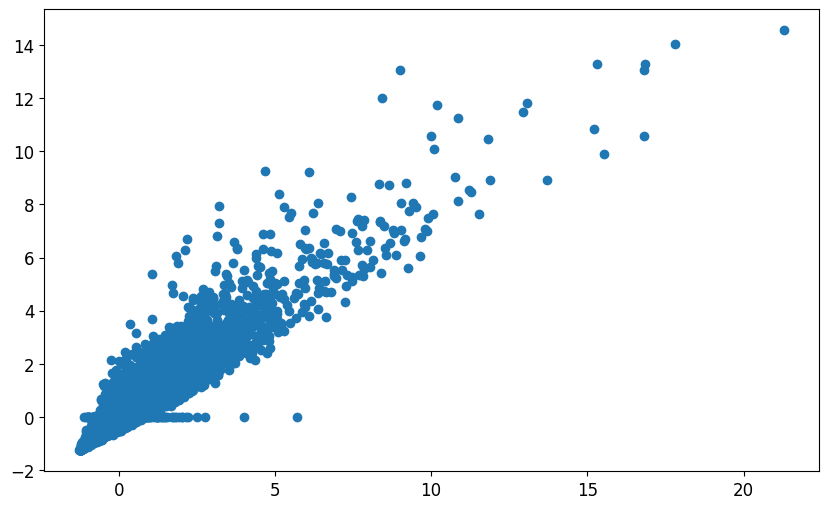

In [25]:
X_small = X_train_scaled[['total_rooms', 'total_bedrooms']]

pca = PCA(n_components=1, random_state= 42)
X_small['component_1'] = pca.fit_transform(X_small)

plt.figure(figsize=(10, 6))
plt.scatter(X_small.total_rooms, X_small.total_bedrooms)
plt.show()

---

PCA подбирает такую линию, вдоль которой лежат точки

* Линейная регрессия - вертикальное расстояние (метод наим квадратов)
* PCA - перпендикуляр к прямой

---

В линейной регрессии мы минимизируем вертикальную разницу:

$\sum(y - y_{hat})^2$

В PCA мы минимизируем среднее расстояние от точек до линии - перпендикуляр к линии:

$\sum(x1_i - {x1_i}')^2 + (x2_i - {x2_i}')^2$

**Как работает PCA из 3d в 2d**

![PCA](pca_1.png)

**Снижение размерности до двух компонент**

In [31]:
dim_reducer2d, components_2d = reduce_dims(X_train_scaled, dims=2, method='pca')
components_2d.head(2)

,component_1,component_2
0,-2.951421,0.121055
1,0.223307,-0.502295


In [28]:
X_train_scaled.shape, components_2d.shape

((13182, 12), (13182, 2))

In [32]:
dim_reducer2d

PCA(n_components=2, random_state=42)

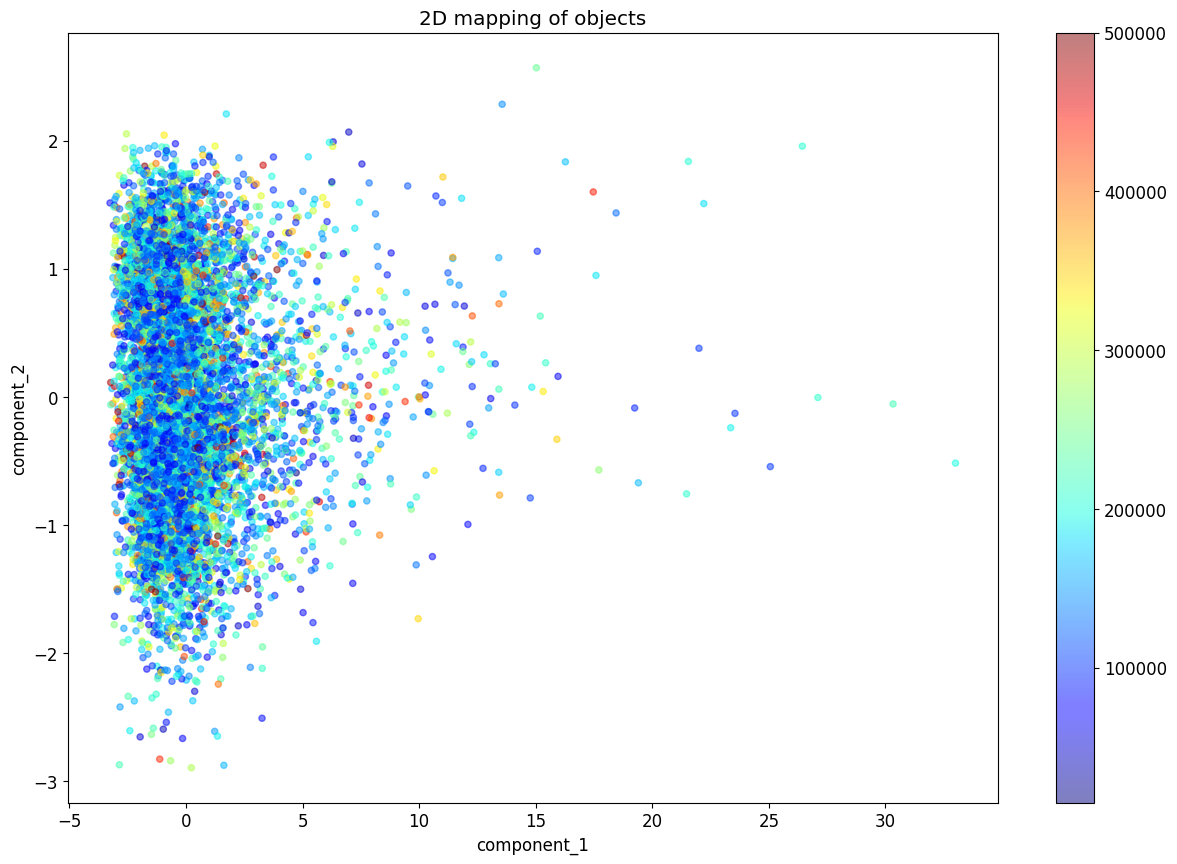

In [39]:
display_components_in_2D_space(components_2d, y_train)

**Снижение размерности до трех компонент**

In [40]:
dim_reducer3d, components_3d = reduce_dims(X_train_scaled, dims=3, method='pca')

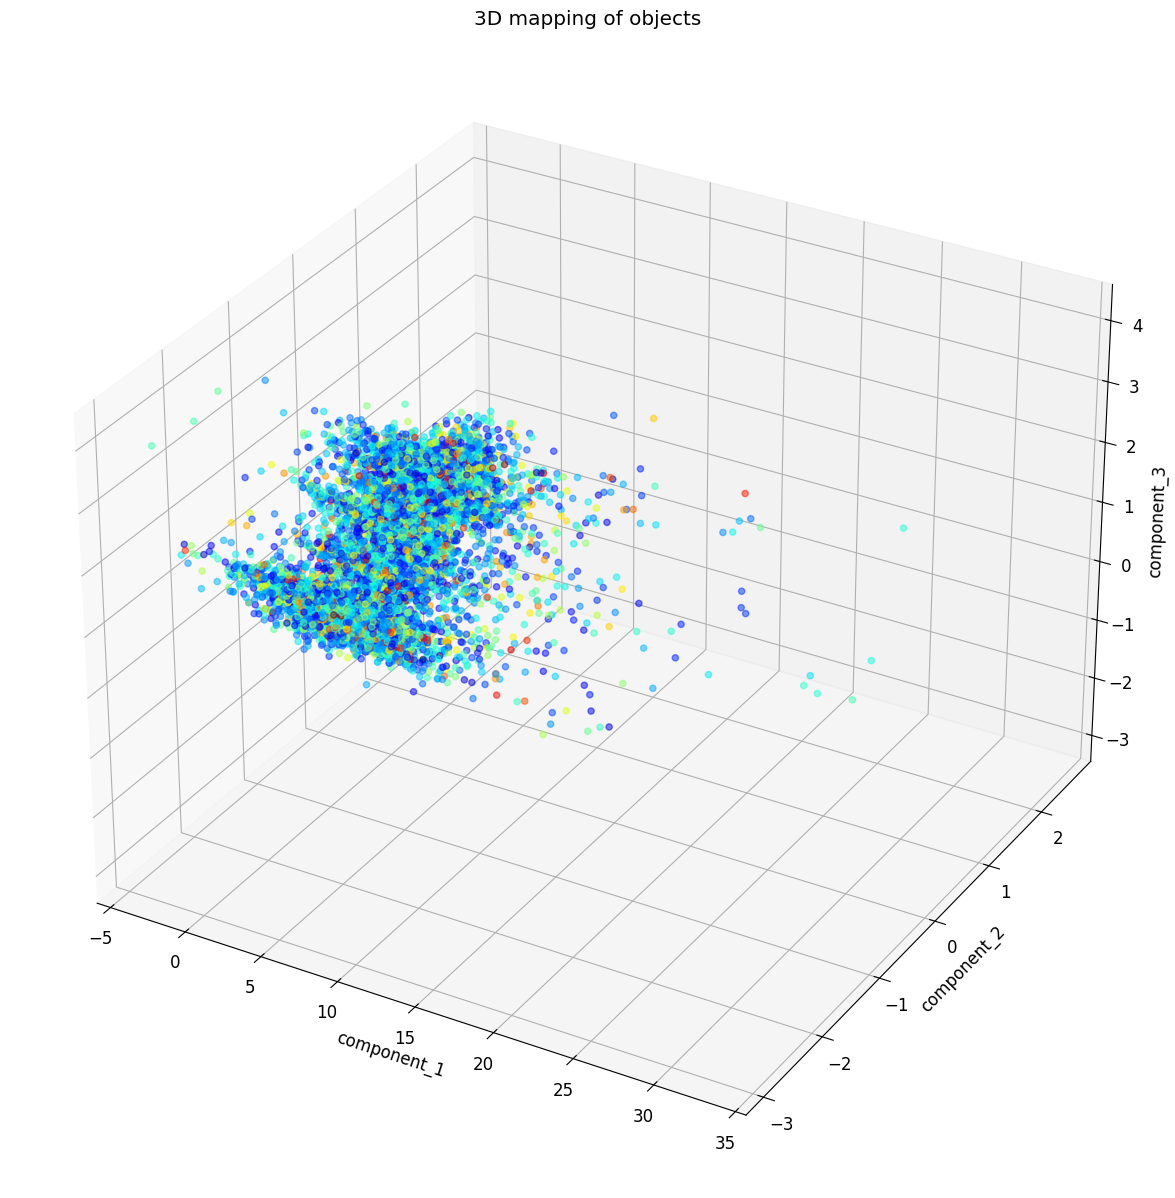

In [43]:
display_components_in_3D_space(components_3d, y_train)

## **TSNE**

Принцип работы метода t-SNE заключается в том, что он пытается сохранять расстояния между каждым входящим вектором.

Шаг 1: В многомерном пространстве создается вероятностное распределение, которое обусловлено расстоянием между точками (преобразование многомерной дистанции между точками в условные вероятности, отражающие сходство точек)

Шаг 2: Алгоритм пытается воссоздать меньше размерное пространство, в котором наилучшим образом сохраняется вероятностное распределение

## **Кластеризация**

Алгоритмы:
- K-means
- [Иерархическая кластеризация](https://towardsdatascience.com/https-towardsdatascience-com-hierarchical-clustering-6f3c98c9d0ca)
- [DBScan](https://towardsdatascience.com/lightning-talk-clustering-with-hdbscan-d47b83d1b03a)

### **Кластеризация: k-means**

Вы указываете кол-во кластеров

1. Центры кластеров случайно инициализируются
2. От каждой точки рассчитывается расстояние до центра каждого кластера
3. Присваиваем каждую точку к тому кластеру, к центру которого она ближе
4. Пересчитываем центры кластеров: берем среднее по всем фичам --> новый центр кластера
    
итеративно повторяем шаги 2-4. Пока центры кластеров не перестанут "двигаться"

Хорошо работает, когда кластеры "шарообразные"

<img src="kmeans_v1.gif">

![image.png](image.png) 

![image.png](image_1.png) 

На картинке хорошо описывается понижение дисперсии (можно взять отсечку в 6)

**Выделение 3 кластеров**

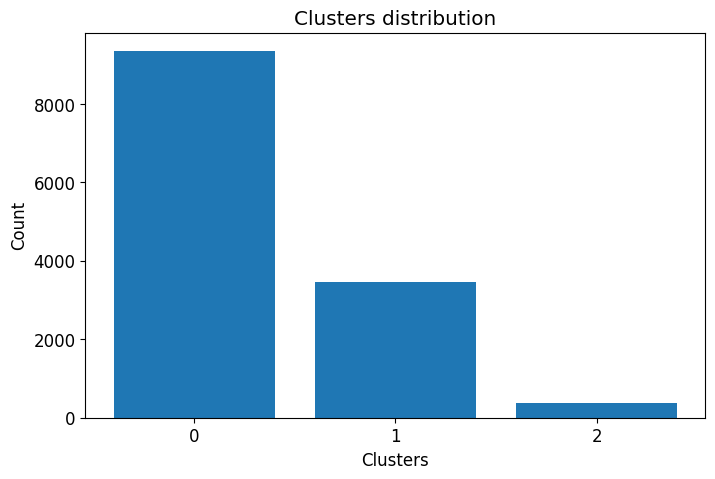

In [45]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
labels_clast_3 = kmeans_3.fit_predict(X_train_scaled)
labels_clast_3 = pd.Series(labels_clast_3, name='clusters_3')

unique, counts = np.unique(labels_clast_3, return_counts=True)
display_clusters_distribution(unique, counts)

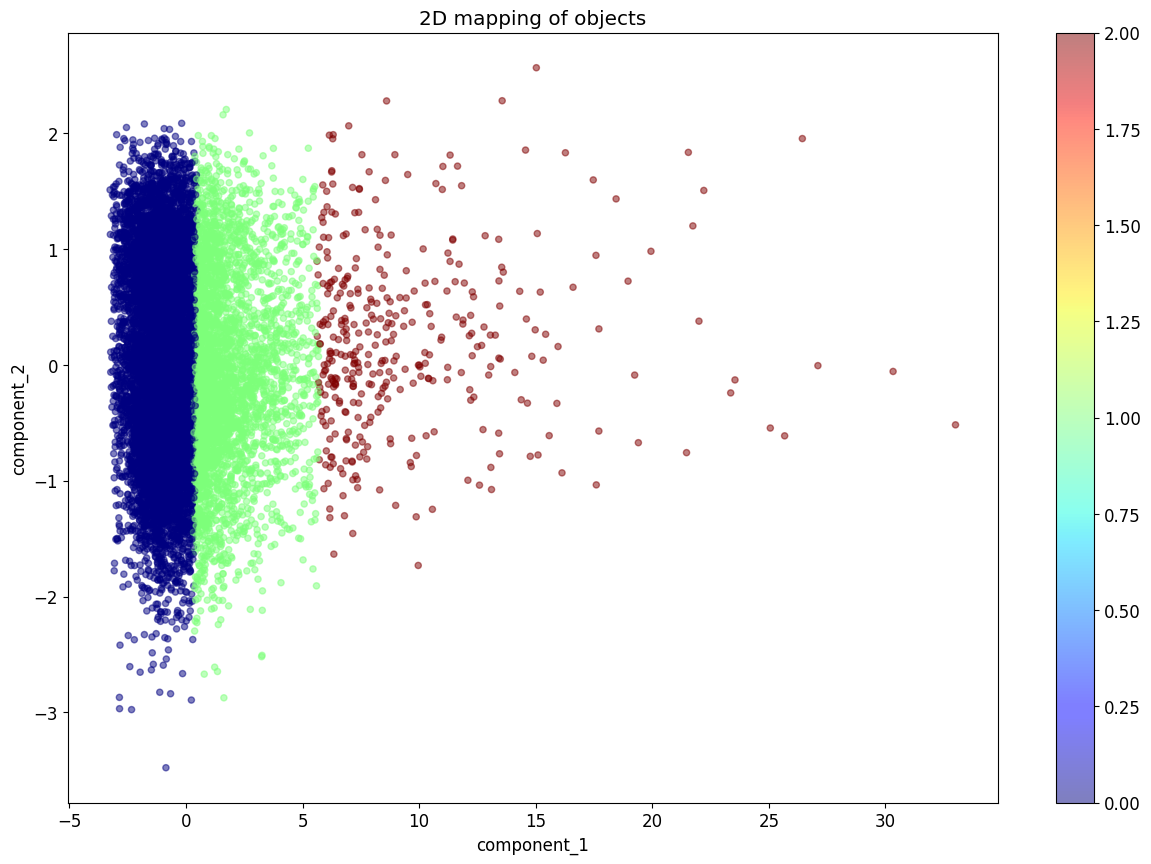

In [46]:
display_components_in_2D_space(components_2d, labels_clast_3)

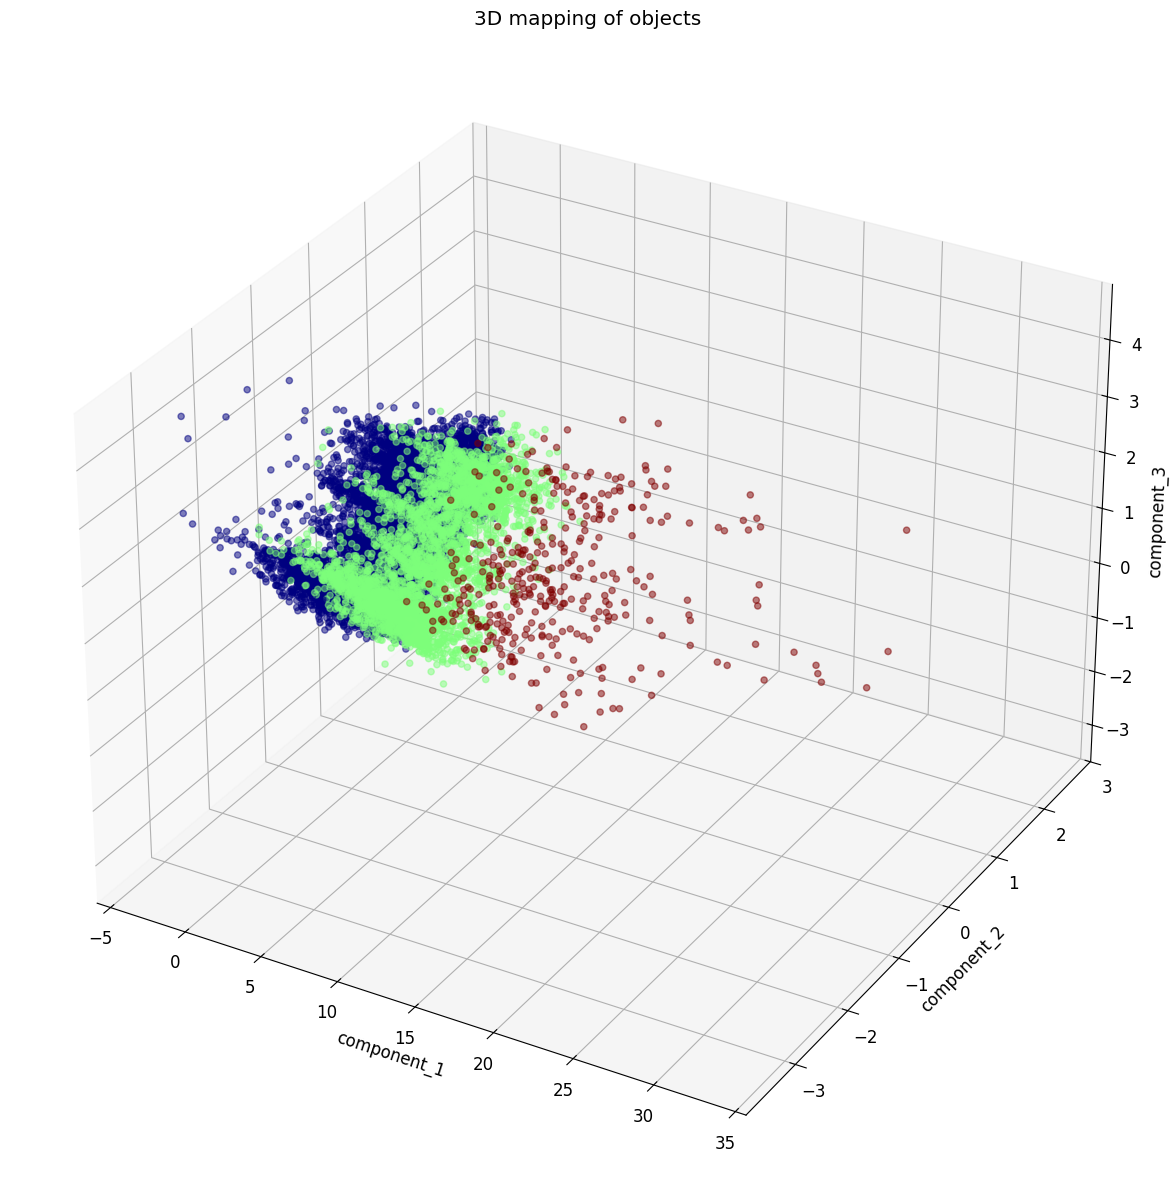

In [47]:
display_components_in_3D_space(components_3d, labels_clast_3)

**Выделение 10 кластеров**

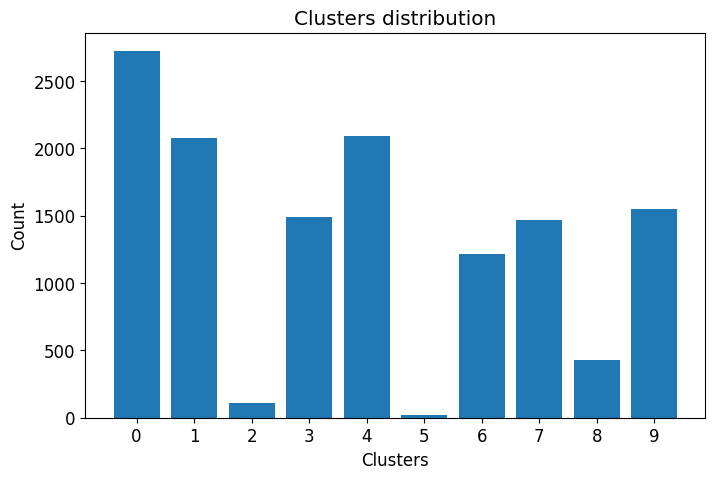

In [49]:
kmeans_10 = KMeans(n_clusters=10, random_state=42)
labels_clast_10 = kmeans_10.fit_predict(X_train_scaled)
labels_clast_10 = pd.Series(labels_clast_10, name='clusters_10')

unique, counts = np.unique(labels_clast_10, return_counts=True)
display_clusters_distribution(unique, counts)

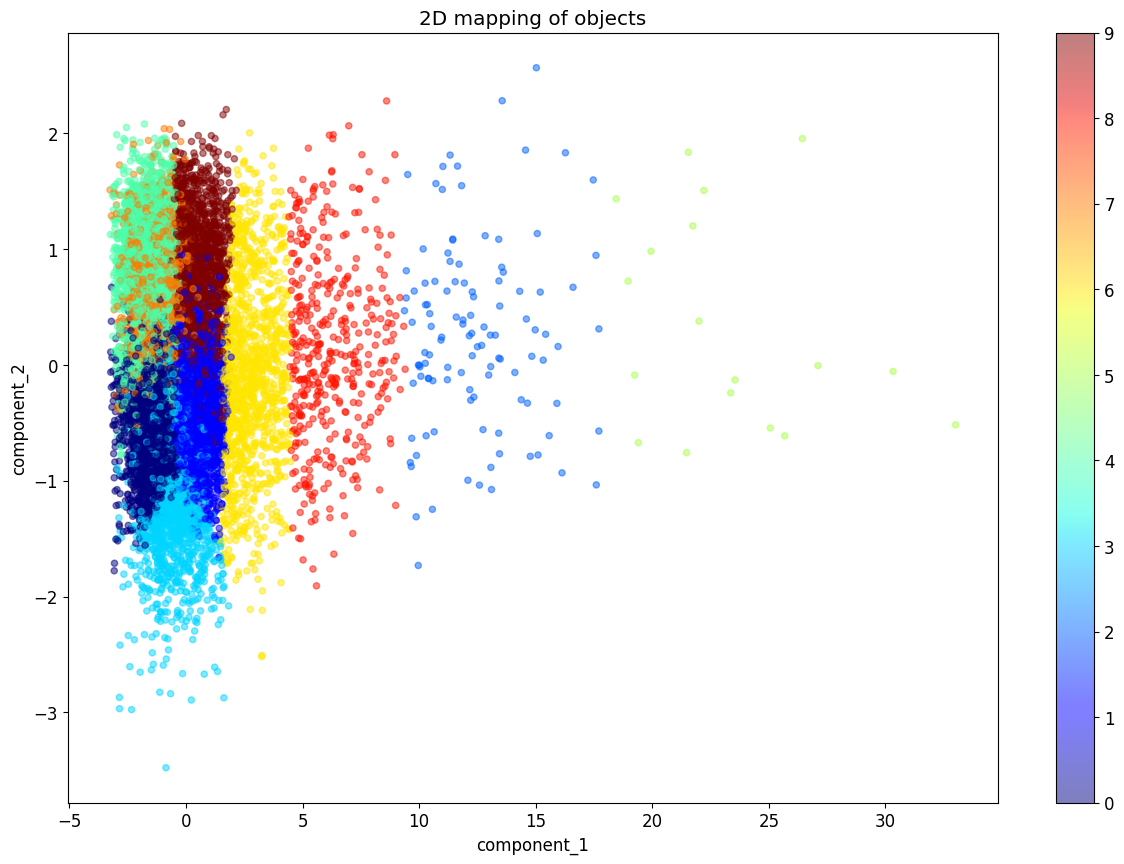

In [50]:
display_components_in_2D_space(components_2d, labels_clast_10)

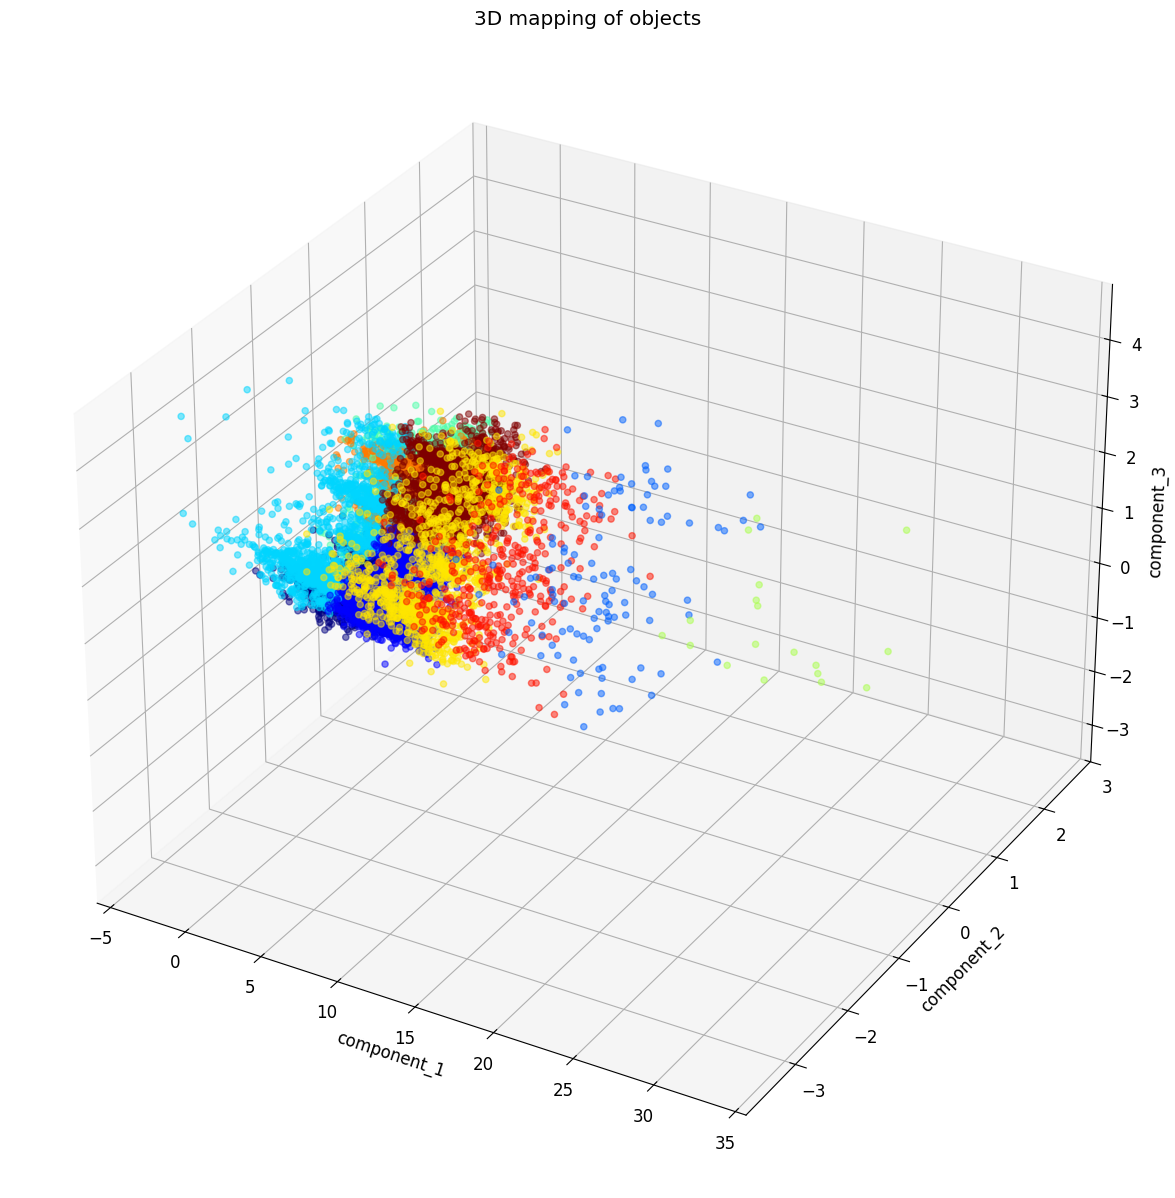

In [51]:
display_components_in_3D_space(components_3d, labels_clast_10)

### **Оценка оптимального кол-ва кластеров**

Дисперсия точек вокруг центров кластеров

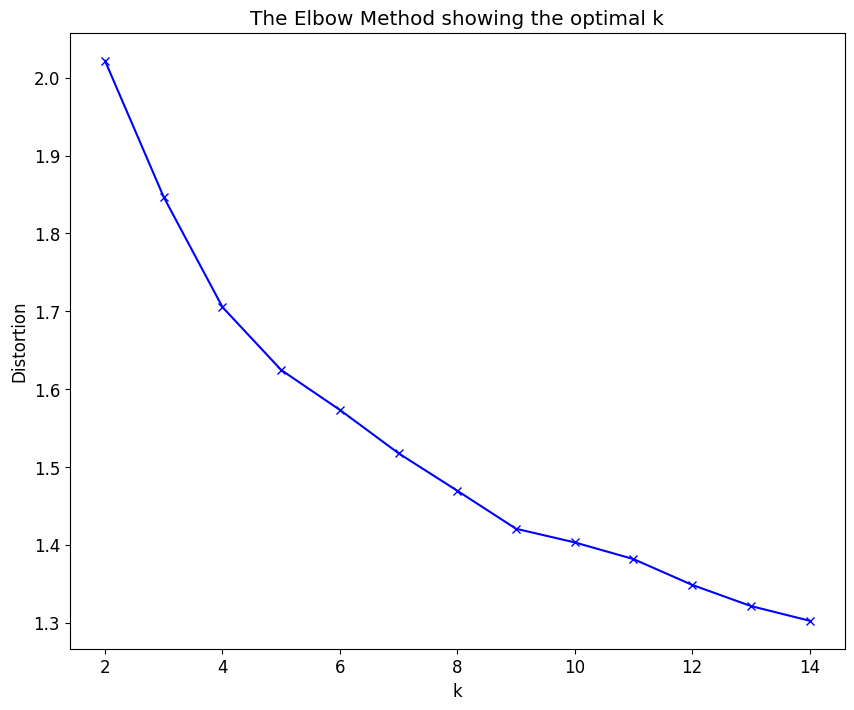

In [52]:
apply_elbow_method(X_train_scaled)

Тут можно взять 4 кластера

### **Добавление новых признаков**

In [53]:
clusters_3_dummies = pd.get_dummies(labels_clast_3, drop_first=True, prefix='clusters_3')
clusters_10_dummies = pd.get_dummies(labels_clast_10, drop_first=True, prefix='clusters_10')

X_train_scaled = pd.concat([X_train_scaled, components_3d, clusters_3_dummies, clusters_10_dummies, df['median_house_value']], axis=1)

X_train_scaled.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,component_1,component_2,component_3,clusters_3_1,clusters_3_2,clusters_10_1,clusters_10_2,clusters_10_3,clusters_10_4,clusters_10_5,clusters_10_6,clusters_10_7,clusters_10_8,clusters_10_9,median_house_value
0,0.198413,0.245383,-1.388889,-1.254978,-1.251445,-1.265284,-1.264615,-0.516324,0.0,1.0,0.0,0.0,-2.951421,0.121055,0.034440,False,False,False,False,False,True,False,False,False,False,False,452600.0
1,0.230159,-0.068602,-0.722222,0.551857,0.257225,0.383188,0.190769,0.715002,0.0,1.0,0.0,0.0,0.223307,-0.502295,0.483534,False,False,True,False,False,False,False,False,False,False,False,358500.0
2,0.111111,-0.060686,0.166667,0.987519,1.014451,0.000000,1.166154,0.113877,1.0,0.0,0.0,0.0,1.015664,-0.584697,-0.375377,True,False,True,False,False,False,False,False,False,False,False,352100.0
3,-1.108466,1.097625,-0.500000,0.478752,0.210983,0.596070,0.267692,0.217890,1.0,0.0,0.0,0.0,0.217492,0.313436,0.643652,False,False,False,False,False,False,False,False,False,False,True,341300.0
4,0.444444,-0.372032,-0.666667,2.190490,1.404624,1.599345,1.323077,0.794200,1.0,0.0,0.0,0.0,2.805033,-1.337981,0.104834,True,False,False,False,False,False,False,True,False,False,False,342200.0


### **Сохранение расширенного обучающего датасета**

In [55]:
X_train_scaled.to_csv('new_housing_prepared.csv', index=False, encoding='utf-8')